# Split processing

> Lets process documents differently based on whether we're predicting a label or embedding into a vector store.

In [1]:
#| default_exp experiments.split_processing

In [64]:
#| export
from typing import Dict, List
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics

from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnableSequence
from langchain.llms import VertexAI
from langchain.vectorstores import Chroma
from langchain.document_loaders import DataFrameLoader

from classifier.schema import get_embedder, get_model, quota_handler, WRITE_PREFIX
from classifier.load import Email, get_batches, get_idx, get_emails_from_frame, \
    get_raw_emails_tejas_case_numbers, get_possible_labels, PROJECT_BUCKET
from classifier.chroma import get_or_make_chroma
from classifier.predict import make_prediction_prompt, get_predictions, write_predictions

## Process

Load training emails

In [3]:
#| export
TEJAS_PREFIX = f"{WRITE_PREFIX}/tejas"

In [10]:
all_emails = get_raw_emails_tejas_case_numbers()
all_emails.shape[0]

3200

In [11]:
train_idx, test_idx = get_idx(prefix=TEJAS_PREFIX)

### Prepare Training Documents

> For inclusion in a vector store for few-shot prompting.

In [12]:
training_emails = list(get_emails_from_frame(
    all_emails,
    'train',
    index_prefix=TEJAS_PREFIX
))
len(training_emails)

2400

In [13]:
training_emails[0]

Email(idx=31716, label='Order Processing', email_subject='Equashield latest - FW: EQ II Catalog 2023 - Cardinal Health.xlsx', email_body='External Email â€“ Please use caution before opening attachments or clicking links  Let us know if you need anything else.    Regards,  Thomas Everitt Customer Service Representative Office    +1 516 684 8200 / Ext: 220 Mobile  +1 516 398 97 25 Fax          +1 516 684 8202 www.equashield.com<http://www.equashield.com/> [cid:image001.png@01DA0CD9.861376B0] [cid:image002.png@01DA0CD9.861376B0]  From: Pavlina Georgieva <pavlina@equashield.com> Sent: Wednesday, November 1, 2023 3:39 PM To: Thomas Everitt <Thomas.e@equashield.com> Subject: EQ II Catalog 2023 - Cardinal Health.xlsx      Regards,  Pavlina Georgieva Logistics Coordinator Office    +1 516 684 8200 / Ext: 202 Fax          +1 516 684 8202 www.equashield.com<http://www.equashield.com/> [cid:image001.png@01DA0CD9.861376B0] [cid:image002.png@01DA0CD9.861376B0]   ________________________________ Co

Load descriptions

In [14]:
data_dir = Path("../../data")
assert data_dir.exists()
experiment_dir = data_dir / 'split_processing'
if not experiment_dir.exists():
    experiment_dir.mkdir()

descriptions_path = data_dir / 'labels.xlsx'
assert descriptions_path.exists()

descriptions = pd.read_excel(descriptions_path).map(lambda s: s.strip() if isinstance(s, str) else s)
descriptions.head()

,CATEGORY,Account/Inquiry,Order Processing,Delivery,Order Discrepancy,Returns,Billing / Invoice,Credits,Pricing,Product Quality,Product Inquiry,Claims,General Inquiry,IT Customer Technology Issue,Program / Promotions
0,SUBCATEGORY,New Account Set Up,Order Entry,Refused Delivery,Keying Error,Customer order error,Freight charge error,Billed Wrong Account,Product Pricing,Adverse Event,General Product inquiry,NaN,Sales,NaN,NaN
1,NaN,Licensing,Will Call,Deliver/ Carrier issue,Wrong Item Shipped,Damage,NaN,Credit Inquiry,Pricing Issue,Defective Item,Product Availability,NaN,NaN,NaN,NaN
2,NaN,Account updates,Emergency Order,Missing/ mis-routed tote,Miss Label,Expired product,NaN,credit not issued / error,NaN,Safety Issue,Restricted item,NaN,NaN,NaN,NaN
3,NaN,NaN,Adjust Order,NaN,Overage,Flu Return,NaN,Pass Thru Credit,NaN,Suspicious Product,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,Shipping Service Change,NaN,Partial Carton,Overstock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# labels = get_possible_labels()
# labels

In [21]:
#| export
def make_description_from_row(row: pd.Series) -> str:
    if row.dropna().shape[0] == 0:
        return ""
    return "Issues including:\n" + "\n".join(["- " + v.strip() for v in row.dropna().values])

In [22]:
descriptions_dict = descriptions.T.iloc[1:, :].apply(make_description_from_row, axis=1).to_dict()
descriptions_dict

{'Account/Inquiry': 'Issues including:\n- New Account Set Up\n- Licensing\n- Account updates',
 'Order Processing': 'Issues including:\n- Order Entry\n- Will Call\n- Emergency Order\n- Adjust Order\n- Shipping Service Change\n- Cancel Order\n- Allocation override',
 'Delivery': 'Issues including:\n- Refused Delivery\n- Deliver/ Carrier issue\n- Missing/ mis-routed tote',
 'Order Discrepancy': 'Issues including:\n- Keying Error\n- Wrong Item Shipped\n- Miss Label\n- Overage\n- Partial Carton\n- Product Excursions\n- Shipped Short Dated product\n- Shortage',
 'Returns': 'Issues including:\n- Customer order error\n- Damage\n- Expired product\n- Flu Return\n- Overstock\n- Product Description Not Clear\n- Recall\n- Shipping Label/Rtn\n- Short Dated product\n- Unauthorized Return',
 'Billing / Invoice': 'Issues including:\n- Freight charge error',
 'Credits': 'Issues including:\n- Billed Wrong Account\n- Credit Inquiry\n- credit not issued / error\n- Pass Thru Credit',
 'Pricing': 'Issues in

In [24]:
# all([l in descriptions_dict.keys() for l in labels])

Define prompt

In [25]:
#| export
TRAIN_PROMPT_TEMPLATE = """Here is an email chain sent to customer service \
and how customer service labeled it for handling, including a description of the label. 
Summarize the email and explain why the email was labeled the way it was.
Do not include any boilerplate content in your summary.
Only use information present in the email chain.
Think through your explanation step-by-step.
-- EMAIL --
{email}
-- LABEL --
{label}
-- LABEL DESCRIPTION --
{label_description}
-- SUMMARY AND EXPLANATION --
"""

TRAIN_PROMPT = PromptTemplate.from_template(TRAIN_PROMPT_TEMPLATE)

In [26]:
llm = VertexAI()

In [27]:
train_processing_chain = TRAIN_PROMPT | llm

In [28]:
#| export
def format_email_for_train_summary(
        email: Email,
        descriptions: Dict[str, str]
        ) -> Dict[str, str]:
    return {
        'email': f'SUBJECT: {email.email_subject}\nBODY: {email.email_body}',
        'label': email.label,
        'label_description': descriptions.get(email.label)
    }

In [29]:
example_train_prompt = TRAIN_PROMPT.format(**format_email_for_train_summary(training_emails[0], descriptions_dict))
print(example_train_prompt)

Here is an email chain sent to customer service and how customer service labeled it for handling, including a description of the label. 
Summarize the email and explain why the email was labeled the way it was.
Do not include any boilerplate content in your summary.
Only use information present in the email chain.
Think through your explanation step-by-step.
-- EMAIL --
SUBJECT: Equashield latest - FW: EQ II Catalog 2023 - Cardinal Health.xlsx
BODY: External Email â€“ Please use caution before opening attachments or clicking links  Let us know if you need anything else.    Regards,  Thomas Everitt Customer Service Representative Office    +1 516 684 8200 / Ext: 220 Mobile  +1 516 398 97 25 Fax          +1 516 684 8202 www.equashield.com<http://www.equashield.com/> [cid:image001.png@01DA0CD9.861376B0] [cid:image002.png@01DA0CD9.861376B0]  From: Pavlina Georgieva <pavlina@equashield.com> Sent: Wednesday, November 1, 2023 3:39 PM To: Thomas Everitt <Thomas.e@equashield.com> Subject: EQ II

In [30]:
llm(example_train_prompt)

' The email chain is about sharing a catalog for the year 2023.\nThe email was labeled as "Order Processing" because it contains information about a catalog, which is related to order processing.\nThe label "Order Processing" is appropriate because the email is about an order for a catalog.\nThe email is not about any of the other issues listed in the label description, such as order entry, will call, emergency order, adjust order, shipping service change, cancel order, or allocation override.'

### Prepare test documents

In [31]:
test_emails = list(get_emails_from_frame(
    all_emails,
    'test',
    index_prefix=TEJAS_PREFIX
))
len(test_emails)

600

In [32]:
#| export
TEST_PROMPT_TEMPLATE = """Here is an email sent to our customer service department.
Summarize it, identifying points of action for customer service if there are any.
Do not include any names, company names, addresses or other identifying information.
Remove boilerplate. 
-- EMAIL SUBJECT --
{subject}
-- EMAIL BODY --
{body}
-- SUMMARY --
"""

TEST_PROMPT = PromptTemplate.from_template(TEST_PROMPT_TEMPLATE)

In [33]:
#| export
def format_email_for_test_summary(
        email: Email,
        ) -> Dict[str, str]:
    return {
        'subject': email.email_subject,
        'body': email.email_body,
    }

In [34]:
example_test_prompt = TEST_PROMPT.format(**format_email_for_test_summary(test_emails[0]))
print(example_test_prompt)

Here is an email sent to our customer service department.
Summarize it, identifying points of action for customer service if there are any.
Do not include any names, company names, addresses or other identifying information.
Remove boilerplate. 
-- EMAIL SUBJECT --
Need signature AC account
-- EMAIL BODY --
Good afternoon,  We have received an order from customer 2057194105. They sent unsigned MRA 3901356789. Can you please reach out to the customer and let them know they have 48 hours to send a signed MRA or we will send back the case for no credit.  Thanks,   [cid:image001.png@01D9F52F.5AD273F0]  Tom Coppedge Returns Lead | Warehouse Operations 2840 Elm Pont Industrial Drive St. Charles, MO. 63301    _________________________________________________  This message is for the designated recipient only and may contain privileged, proprietary or otherwise private information. If you have received it in error, please notify the sender immediately and delete the original. Any other use of 

In [35]:
test_processing_chain = TEST_PROMPT | llm

In [36]:
test_processing_chain.invoke(format_email_for_test_summary(test_emails[0]))

' Customer 2057194105 sent an unsigned MRA 3901356789 with their order.\n\n**Action:** Customer service should reach out to the customer and inform them that they have 48 hours to send a signed MRA or the case will be returned for no credit.'

### Process everything

In [37]:
#| export
@quota_handler
def batch_predict(prompts: List[Dict[str, str]], chain: RunnableSequence) -> List[str]:
    return chain.batch(prompts)

Process training data

In [ ]:
## Takes about 1.25 hours
# train_summaries = []

# pbar = tqdm(total=len(training_emails), ncols=80, leave=True)

# try:
#     for batch in get_batches(training_emails, 5):
#         batch_prompts = [format_email_for_train_summary(e, descriptions_dict) for e in batch]
#         train_summaries.extend(batch_predict(batch_prompts, train_processing_chain))
#         pbar.update(len(batch))
# except:
#     pass
# finally:
#     pbar.close()

# len(train_summaries) == len(training_emails)

100%|█████████████████████████████████████| 2400/2400 [1:13:02<00:00,  1.83s/it]


True

In [44]:
# train_summary_df = pd.DataFrame(
#     zip(
#         train_summaries,
#         [t.idx for t in training_emails],
#         [t.label for t in training_emails]
#     ),
#     columns=['summary', 'idx', 'label']
# )
# train_summary_df.to_csv(
#     f'gs://{PROJECT_BUCKET}/{TEJAS_PREFIX}/split_train_summaries.csv', 
#     index=False)

In [43]:
train_summary_df = pd.read_csv(
    f'gs://{PROJECT_BUCKET}/{TEJAS_PREFIX}/split_train_summaries.csv',
    usecols=['summary', 'idx', 'label']
    )
train_summary_df.head()

,summary,idx,label
0,The email chain is about sharing a catalog fo...,31716,Order Processing
1,**Summary**\nThe customer sent an email to th...,35200,Billing / Invoice
2,**Summary**\nThe email is a notification from...,462,Account/Inquiry
3,**Summary:**\nThe email is about an order tha...,3705,Order Processing
4,**Summary**\nThe email is a notification from...,25300,Account/Inquiry


Process test

In [45]:
## Takes about ~15 minutes
# test_summaries = []

# pbar = tqdm(total=len(test_emails), ncols=80, leave=True)

# try:
#     for batch in get_batches(test_emails, 5):
#         batch_prompts = [format_email_for_test_summary(e) for e in batch]
#         test_summaries.extend(batch_predict(batch_prompts, test_processing_chain))
#         pbar.update(len(batch))
# except:
#     pass
# finally:
#     pbar.close()

# len(test_summaries) == len(test_emails)

In [46]:
# test_summary_df = pd.DataFrame(
#     zip(
#         test_summaries,
#         [t.idx for t in test_emails],
#         [t.label for t in test_emails]
#     ),
#     columns=['summary', 'idx', 'label']
# )
# test_summary_df.to_csv(
#     f'gs://{PROJECT_BUCKET}/{TEJAS_PREFIX}/split_test_summaries.csv', 
#     index=False)

In [47]:
test_summary_df = pd.read_csv(
    f'gs://{PROJECT_BUCKET}/{TEJAS_PREFIX}/split_test_summaries.csv', 
    usecols=['summary', 'idx', 'label']
)

## Build our vector store

In [48]:
chroma_documents = DataFrameLoader(
    train_summary_df,
    page_content_column='summary').load()
len(chroma_documents)

2400

In [49]:
embedder = get_embedder()

In [50]:
chroma = get_or_make_chroma(
    data_dir=experiment_dir,
    documents=chroma_documents
)

## Predict

In [51]:
prediction_documents = DataFrameLoader(
    test_summary_df, 
    page_content_column='summary'
).load()

In [52]:
print(
    make_prediction_prompt(
        prediction_documents[0],
        chroma=chroma,
        limit=3
    ))

Our customer service team wants to classify emails so they can be sent to the right support team.
Here are the labels they use;

--LABELS--
- Order Processing
- Product Inquiry
- Account/Inquiry
- General Inquiry
- Returns
- Billing / Invoice
- Delivery
- Credits
- Order Discrepancy
- Pricing
- Program / Promotions

Below are a series of emails that have already been labeled, use their example to identify what label the final email should get.
Your answer must be one of the options in the --LABELS-- list.
Return only the label from the above list that you chose.

--EMAILS--
EMAIL: **Summary:**
- Customer 2057201348 sent two orders with an unsigned MRA (Mutual Recognition Agreement) 3901263910.
- Customer service needs to contact the customer and inform them that they have 48 hours to send a signed MRA, or the case will be returned for no credit.

**Explanation:**
- The email is about an issue with a customer's order, specifically the lack of a signed MRA.
- The customer service represe

Get predictions

In [53]:
prediction_prompts = [
    make_prediction_prompt(s, chroma, 3) for s in tqdm(
        prediction_documents, 
        leave=False, 
        ncols=80)]

In [54]:
predictions = get_predictions(
    llm=llm,
    prompts=prediction_prompts
)

In [59]:
predictions_df = pd.DataFrame(
    list(zip(
        [s.strip() for s in predictions], 
        [d.metadata.get('label') for d in prediction_documents],
        [d.metadata.get('idx') for d in prediction_documents],
        prediction_prompts,
        [f"-- SUBJECT --\n{e.email_subject}\n-- BODY --\n{e.email_body}" for e in test_emails]
    )),
    columns=['prediction', 'label', 'idx', 'prompt', 'email']
)
predictions_df.to_csv(experiment_dir / 'sample_predictions.csv', index=False)

## Evaluate

In [60]:
performance_kwargs = {
    'y_true': predictions_df.label,
    'y_pred': predictions_df.prediction
}

In [61]:
metrics.accuracy_score(**performance_kwargs)

0.6916666666666667

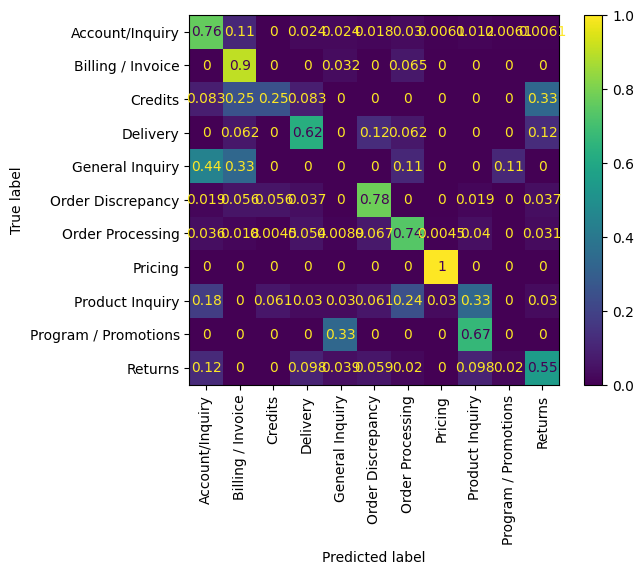

In [62]:
matrix_display = metrics.ConfusionMatrixDisplay.from_predictions(
    normalize='true',
    xticks_rotation='vertical',
    **performance_kwargs
)

In [65]:
performance_report_str = metrics.classification_report(
    zero_division=np.nan,
    output_dict=False,
    **performance_kwargs)
print(performance_report_str)

                      precision    recall  f1-score   support

     Account/Inquiry       0.83      0.76      0.79       164
   Billing / Invoice       0.47      0.90      0.62        31
             Credits       0.33      0.25      0.29        12
            Delivery       0.29      0.62      0.39        16
     General Inquiry       0.00      0.00       nan         9
   Order Discrepancy       0.63      0.78      0.69        54
    Order Processing       0.90      0.74      0.81       224
             Pricing       0.50      1.00      0.67         3
     Product Inquiry       0.37      0.33      0.35        33
Program / Promotions       0.00      0.00       nan         3
             Returns       0.62      0.55      0.58        51

            accuracy                           0.69       600
           macro avg       0.45      0.54      0.58       600
        weighted avg       0.73      0.69      0.72       600



## Export

In [66]:
import nbdev; nbdev.nbdev_export()